In [4]:
!pip install snowflake-connector-python
!pip install pandas
!pip install matplotlib seaborn plotly

In [5]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
conn = snowflake.connector.connect(
    user='',
    password='',
    account='',
    warehouse='COMPUTE_WH',
    database='Logistics_DB',
    schema='Transformed_Data'
)

Business Insights Summary

This exploratory data analysis (EDA) evaluates shipment performance across seasons, delivery speed, delay patterns, and route characteristics. The goal is to identify operational patterns that can guide capacity planning, routing optimization, and strategic investment decisions.

EDA Goals:
1. Seasonality & Number of Trips
2. Seasonality's Correlation to speed (Distance/Time)
3. Seasonality's Correlation to Delays
4. Top Routes
5. Three-Year Profit & Loss Analysis

In [7]:
query = "SELECT * FROM delivery_fact_table;" 
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_28040/2390383813.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,TRIP_ID,DELIVERY_DELAYED_MINUTES,SEASON,ACTUAL_DISTANCE_MILES,ACTUAL_DURATION_HOURS,ROUTE
0,TRIP00074713,67,Summer,699,13.1,GA -> FL
1,TRIP00074714,0,Summer,266,4.8,NV -> CA
2,TRIP00074715,161,Summer,675,11.6,CO -> MO
3,TRIP00074716,230,Summer,1268,21.5,NV -> TX
4,TRIP00074717,289,Summer,1246,21.2,MN -> TX


In [8]:
df.describe().round(2)

,DELIVERY_DELAYED_MINUTES,ACTUAL_DISTANCE_MILES,ACTUAL_DURATION_HOURS
count,85410.00,85410.00,85410.00
mean,120.12,1430.27,25.01
std,120.21,801.93,14.19
min,0.00,90.00,1.40
25%,0.00,717.00,12.60
50%,90.00,1297.50,23.00
75%,225.00,2147.00,36.90
max,360.00,3391.00,67.80


I. Seasonality of Trip Volume

In [9]:
season_counts = df['SEASON'].value_counts().sort_index()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_counts = season_counts.reindex(season_order)

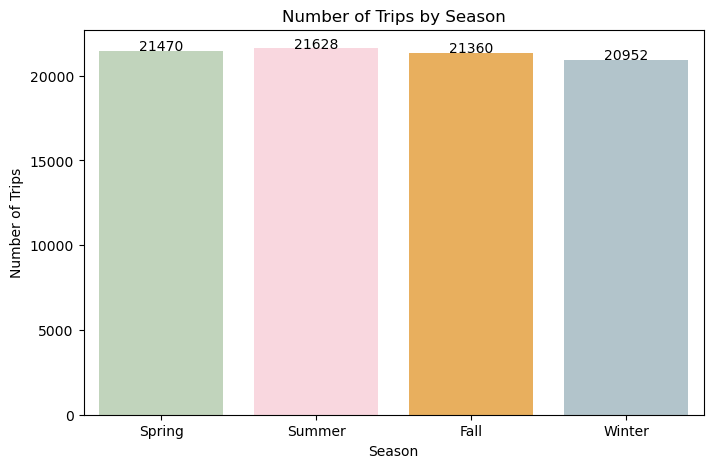

In [44]:
plt.figure(figsize=(8,5))
sns.barplot(x=season_counts.index, y=season_counts.values,palette=['#BFD8B8', '#FFD1DC', '#FFB347', '#AEC6CF'])
plt.title("Number of Trips by Season")
plt.xlabel("Season")
plt.ylabel("Number of Trips")
for i, v in enumerate(season_counts.values):
    plt.text(i, v + 5, int(v), ha='center')

plt.show()

Finding: Trip counts across Spring, Summer, Fall, and Winter vary only slightly, with less than a 3% difference between the highest and lowest seasons.

Business Implications:
1. Demand is stable year-round, reducing the need for seasonal staffing changes or temporary labor.
2. Fleet and warehouse capacity can be planned consistently, minimizing cost spikes often associated with seasonal fluctuations.
3. Budgeting and forecasting are simpler because the business does not experience peak-season volatility.


II. Delivery Speeds Across Seasons

In [11]:
df['AVG_SPEED_MPH'] = df['ACTUAL_DISTANCE_MILES'] / df['ACTUAL_DURATION_HOURS']
df['AVG_SPEED_MPH'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
df['AVG_SPEED_MPH'] = df['AVG_SPEED_MPH'].round(2)

In [12]:
#Removing outliers that are lower than 5mph and higher than 120mph in speed
df_clean = df[(df['AVG_SPEED_MPH'] >= 5) & (df['AVG_SPEED_MPH'] <= 120)]

In [13]:
df[['ACTUAL_DISTANCE_MILES', 'ACTUAL_DURATION_HOURS', 'AVG_SPEED_MPH']].head()

,ACTUAL_DISTANCE_MILES,ACTUAL_DURATION_HOURS,AVG_SPEED_MPH
0,699,13.1,53.36
1,266,4.8,55.42
2,675,11.6,58.19
3,1268,21.5,58.98
4,1246,21.2,58.77


In [14]:
# Group by season and get average speed
speed_by_season = df_clean.groupby('SEASON')['AVG_SPEED_MPH'].mean().reindex(['Spring', 'Summer', 'Fall', 'Winter']).round(2)
print(speed_by_season)

SEASON
Spring    57.47
Summer    57.52
Fall      57.50
Winter    57.53
Name: AVG_SPEED_MPH, dtype: float64


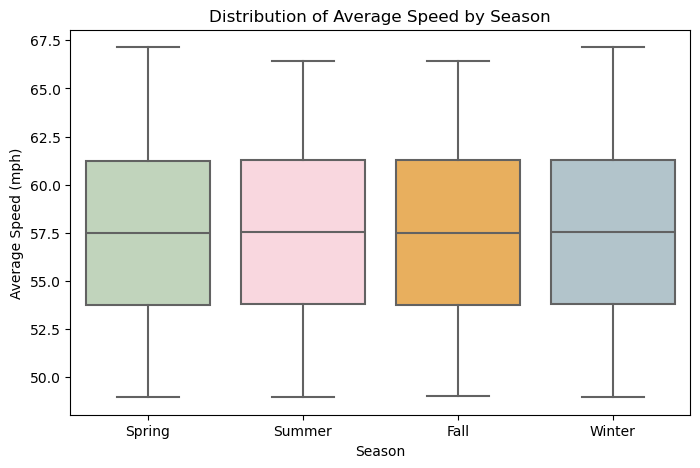

In [45]:
plt.figure(figsize=(8,5))
sns.boxplot(x='SEASON', y='AVG_SPEED_MPH', data=df_clean, order=['Spring','Summer','Fall','Winter'],palette=['#BFD8B8', '#FFD1DC', '#FFB347', '#AEC6CF'])
plt.title("Distribution of Average Speed by Season")
plt.xlabel("Season")
plt.ylabel("Average Speed (mph)")

plt.show()

In [16]:
from scipy.stats import f_oneway

spring = df_clean[df_clean['SEASON']=='Spring']['AVG_SPEED_MPH']
summer = df_clean[df_clean['SEASON']=='Summer']['AVG_SPEED_MPH']
fall = df_clean[df_clean['SEASON']=='Fall']['AVG_SPEED_MPH']
winter = df_clean[df_clean['SEASON']=='Winter']['AVG_SPEED_MPH']

f_stat, p_val = f_oneway(spring, summer, fall, winter)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

ANOVA F-statistic: 0.77, p-value: 0.5079


Finding: Average driver speed remains around 57 MPH in all seasons, with a p-value of 0.5079, indicating no statistical difference.

Business Implications:
1. Weather does not materially impact driver speeds, suggesting effective route planning and safety protocols.
2. Service Level Agreements (SLAs) can maintain a consistent delivery promise throughout the year.
3. Since speed variability is not a factor, optimization efforts should focus on route structure and operational bottlenecks, not seasonal adjustments.

III. Delays Are Operational, Not Seasonal

In [17]:
df_clean[['SEASON','DELIVERY_DELAYED_MINUTES']].head()

,SEASON,DELIVERY_DELAYED_MINUTES
0,Summer,67
1,Summer,0
2,Summer,161
3,Summer,230
4,Summer,289


In [18]:
avg_delay_by_season = df_clean.groupby('SEASON')['DELIVERY_DELAYED_MINUTES'].mean().reindex(['Spring','Summer','Fall','Winter']).round(2)
print(avg_delay_by_season)

SEASON
Spring    120.78
Summer    119.86
Fall      119.39
Winter    120.47
Name: DELIVERY_DELAYED_MINUTES, dtype: float64


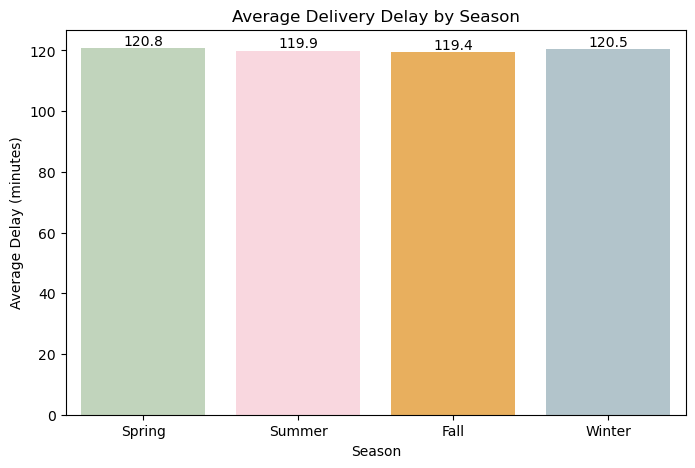

In [46]:
plt.figure(figsize=(8,5))
sns.barplot(x=avg_delay_by_season.index, y=avg_delay_by_season.values,palette=['#BFD8B8', '#FFD1DC', '#FFB347', '#AEC6CF'])
plt.title("Average Delivery Delay by Season")
plt.xlabel("Season")
plt.ylabel("Average Delay (minutes)")

for i, v in enumerate(avg_delay_by_season.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center')

plt.show()

In [20]:
from scipy.stats import f_oneway

spring = df_clean[df_clean['SEASON']=='Spring']['DELIVERY_DELAYED_MINUTES']
summer = df_clean[df_clean['SEASON']=='Summer']['DELIVERY_DELAYED_MINUTES']
fall = df_clean[df_clean['SEASON']=='Fall']['DELIVERY_DELAYED_MINUTES']
winter = df_clean[df_clean['SEASON']=='Winter']['DELIVERY_DELAYED_MINUTES']

f_stat, p_val = f_oneway(spring, summer, fall, winter)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")


ANOVA F-statistic: 0.57, p-value: 0.6333


Finding: Delays average around 120 minutes in all seasons, with no statistically meaningful differences (p-value: 0.6333).

Business Implications:
1. Delays appear to stem from logistics processes and route-specific issues, not seasonal weather.
2. Investments into winter-specific mitigation strategies (e.g., additional buffer time) would not reduce delays.
3. Improvement efforts should target:
    * High-congestion corridors
    * Carrier performance variability
    * Pickup/delivery facility efficiency
    * Scheduling alignment and dwell time



IV. Key High-Volume Routes

In [21]:
df_clean[['TRIP_ID', 'ROUTE']].head()

,TRIP_ID,ROUTE
0,TRIP00074713,GA -> FL
1,TRIP00074714,NV -> CA
2,TRIP00074715,CO -> MO
3,TRIP00074716,NV -> TX
4,TRIP00074717,MN -> TX


In [22]:
top_routes = df_clean['ROUTE'].value_counts().sort_values(ascending=False).head(10)
print(top_routes)

ROUTE
OH -> PA    1628
PA -> NY    1537
OH -> CA    1534
OH -> OR    1525
NV -> CA    1522
WA -> TX    1518
NC -> TN    1514
AZ -> PA    1507
CO -> MO    1505
TX -> NY    1502
Name: count, dtype: int64


In [23]:
num_unique_routes = df_clean['ROUTE'].nunique()
print(f"Number of unique routes: {num_unique_routes}")

Number of unique routes: 58


There are in total of 58 routes and OH to PA route is the most common among all.

In [24]:
# Total distance per route
distance_by_route = df_clean.groupby('ROUTE')['ACTUAL_DISTANCE_MILES'].sum().sort_values(ascending=False).head(10)
print(distance_by_route)

ROUTE
FL -> WA    4683089
PA -> WA    4118647
WA -> NC    3964388
NC -> WA    3912108
NV -> NY    3895558
NC -> OR    3817963
AZ -> PA    3706749
OH -> OR    3661229
OH -> CA    3583020
OR -> OH    3533761
Name: ACTUAL_DISTANCE_MILES, dtype: int64


Out of all routes, FL to WA route has the longest distance, 4,683,089 miles across all trips.

In [25]:
# Total delay per route
delay_by_route = df_clean.groupby('ROUTE')['DELIVERY_DELAYED_MINUTES'].sum().sort_values(ascending=False).head(10)
print(delay_by_route)

ROUTE
OH -> PA    196201
OH -> CA    196040
OR -> WA    187214
TX -> IN    187183
WA -> TX    186527
TN -> MN    186280
NV -> NY    184664
CO -> MO    184358
AZ -> PA    183643
TX -> NY    183572
Name: DELIVERY_DELAYED_MINUTES, dtype: int64


Among all routes, OH to PA route incurs the most delays, 196,201 minutes across all delivery trips.

In [26]:
query = "SELECT * FROM price_per_gallon;" 
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_28040/237521057.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,PURCHASE_DATE,PRICE_PER_GALLON,LOCATION_STATE
0,2023-10-22 05:00:00,3.399,MN
1,2024-08-04 08:00:00,3.180,AZ
2,2022-08-23 13:00:00,3.804,NE
3,2022-04-20 00:00:00,3.579,NY
4,2024-06-13 09:00:00,3.422,AZ


V. Profit and Loss Analysis

Revenue

In [49]:
query = "SELECT (SELECT sum(REVENUE_2022) FROM TRUCK_PROFIT_2022)AS REVENUE_2022, (SELECT sum(REVENUE_2023) FROM TRUCK_PROFIT_2023)AS REVENUE_2023, (SELECT sum(REVENUE_2024) FROM TRUCK_PROFIT_2024)AS REVENUE_2024;"
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_28040/1075470551.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,REVENUE_2022,REVENUE_2023,REVENUE_2024
0,86029772.53,85434393.37,85880094.0


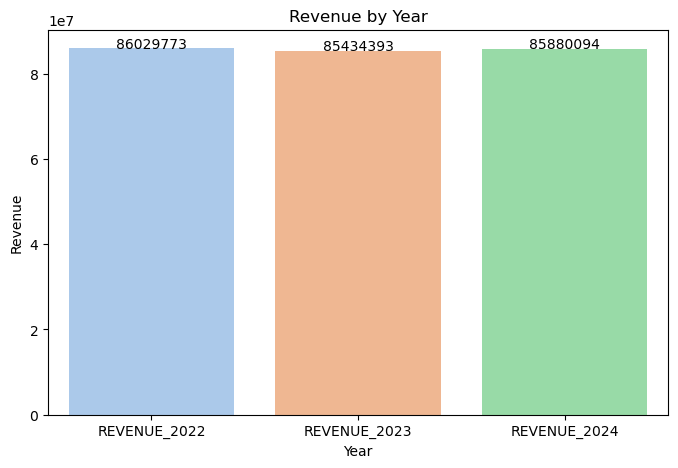

In [51]:
df_long = df.melt(var_name='Year', value_name='REVENUE')

plt.figure(figsize=(8,5))
sns.barplot(x='Year', y='REVENUE', data=df_long, palette='pastel')
plt.title("Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Revenue")

for i, v in enumerate(df_long['REVENUE']):
    plt.text(i, v + 1000, f"{v:.0f}", ha='center')

plt.show()

Cost of Fuel

In [27]:
df['PURCHASE_DATE'] = pd.to_datetime(df['PURCHASE_DATE'])

# Create 'Year-Month' column
df['YearMonth'] = df['PURCHASE_DATE'].dt.to_period('M')

# Group by 'YearMonth' and calculate average price
monthly_avg = df.groupby('YearMonth')['PRICE_PER_GALLON'].mean().round(2).reset_index()

monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()

print(monthly_avg)

    YearMonth  PRICE_PER_GALLON
0  2022-01-01              4.21
1  2022-02-01              4.20
2  2022-03-01              4.20
3  2022-04-01              4.20
4  2022-05-01              4.20
5  2022-06-01              4.19
6  2022-07-01              4.19
7  2022-08-01              4.20
8  2022-09-01              4.19
9  2022-10-01              4.20
10 2022-11-01              4.19
11 2022-12-01              4.20
12 2023-01-01              3.85
13 2023-02-01              3.84
14 2023-03-01              3.86
15 2023-04-01              3.86
16 2023-05-01              3.85
17 2023-06-01              3.84
18 2023-07-01              3.85
19 2023-08-01              3.85
20 2023-09-01              3.84
21 2023-10-01              3.85
22 2023-11-01              3.85
23 2023-12-01              3.85
24 2024-01-01              3.65
25 2024-02-01              3.65
26 2024-03-01              3.64
27 2024-04-01              3.65
28 2024-05-01              3.65
29 2024-06-01              3.66
30 2024-

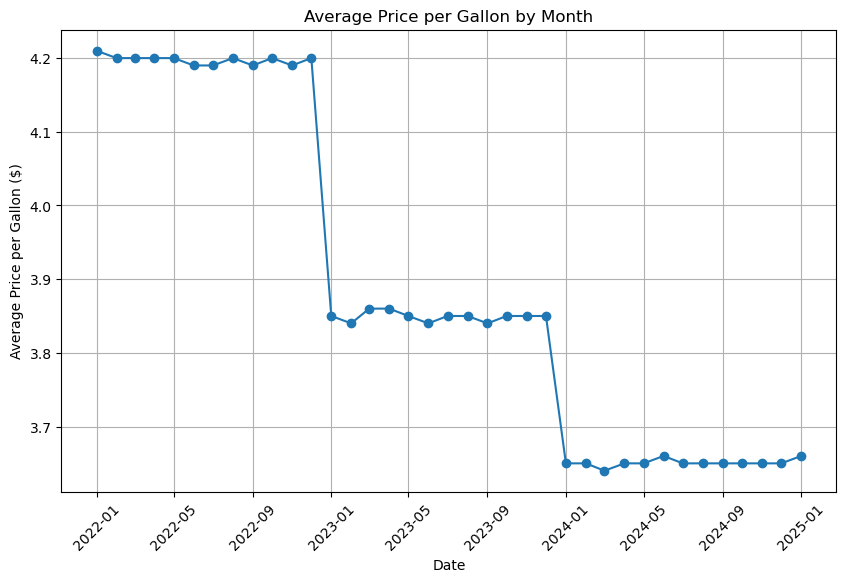

In [28]:
plt.figure(figsize=(10,6))
plt.plot(monthly_avg['YearMonth'], monthly_avg['PRICE_PER_GALLON'], marker='o')

plt.xlabel('Date')
plt.ylabel('Average Price per Gallon ($)')
plt.title('Average Price per Gallon by Month')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

The cost of fuel has dropped from 4.20 per gallon in 2022 to 3.65 per gallon in 2024

In [36]:
query = "SELECT (SELECT sum(FUEL_COST_2022) FROM TRUCK_PROFIT_2022)AS FUEL_2022, (SELECT sum(FUEL_COST_2023) FROM TRUCK_PROFIT_2023)AS FUEL_2023, (SELECT sum(FUEL_COST_2024) FROM TRUCK_PROFIT_2024)AS FUEL_2024;"
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_28040/467897131.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,FUEL_2022,FUEL_2023,FUEL_2024
0,34252086.88,31002386.18,29995043.35


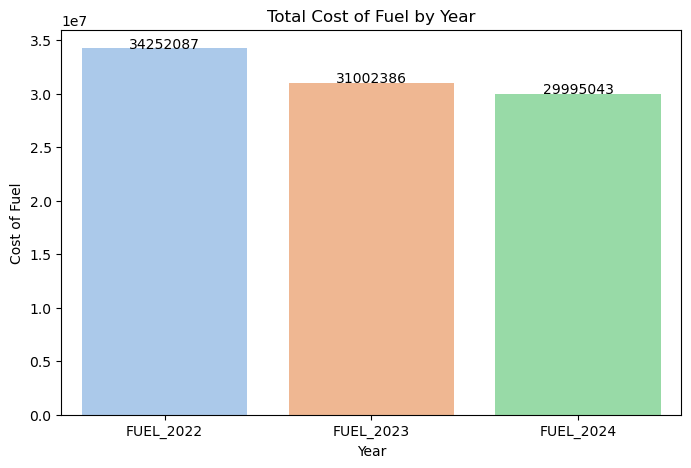

In [37]:
df_long = df.melt(var_name='Year', value_name='Fuel_Cost')

plt.figure(figsize=(8,5))
sns.barplot(x='Year', y='Fuel_Cost', data=df_long, palette='pastel')
plt.title("Total Cost of Fuel by Year")
plt.xlabel("Year")
plt.ylabel("Cost of Fuel")

for i, v in enumerate(df_long['Fuel_Cost']):
    plt.text(i, v + 1000, f"{v:.0f}", ha='center')

plt.show()

Cost of Maintenance

The total cost of fuel has decreased over the three years, which aligns with the cost per gallon trend.

In [33]:
query = "SELECT (SELECT sum(MAINTENANCE_COST_2022) FROM TRUCK_PROFIT_2022)AS MAINTENANCE_2022, (SELECT sum(MAINTENANCE_COST_2023) FROM TRUCK_PROFIT_2023)AS MAINTENANCE_2023, (SELECT sum(MAINTENANCE_COST_2024) FROM TRUCK_PROFIT_2024)AS MAINTENANCE_2024;"
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_28040/310081314.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,MAINTENANCE_2022,MAINTENANCE_2023,MAINTENANCE_2024
0,1931926.19,1974808.56,1823838.53


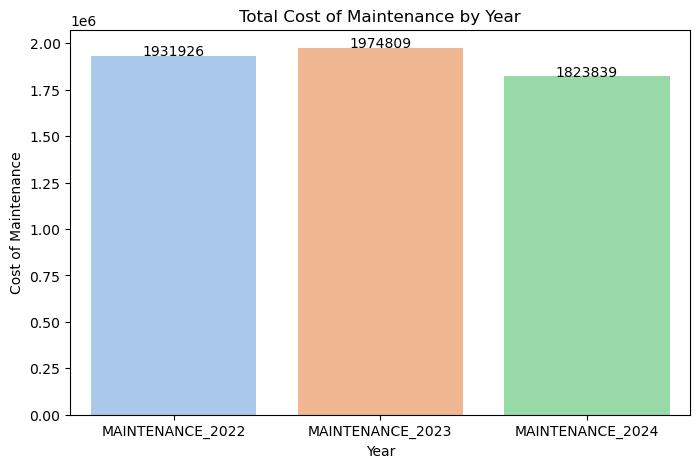

In [35]:
df_long = df.melt(var_name='Year', value_name='Maintenance_Cost')

plt.figure(figsize=(8,5))
sns.barplot(x='Year', y='Maintenance_Cost', data=df_long, palette='pastel')
plt.title("Total Cost of Maintenance by Year")
plt.xlabel("Year")
plt.ylabel("Cost of Maintenance")

for i, v in enumerate(df_long['Maintenance_Cost']):
    plt.text(i, v + 1000, f"{v:.0f}", ha='center')

plt.show()

The total cost of maintenance over the three years varied, with 2023 being the highest and 2024 being the lowest.

Profit

In [53]:
query = "SELECT (SELECT sum(PROFIT_2022) FROM TRUCK_PROFIT_2022)AS PROFIT_2022, (SELECT sum(PROFIT_2023) FROM TRUCK_PROFIT_2023)AS PROFIT_2023, (SELECT sum(PROFIT_2024) FROM TRUCK_PROFIT_2024)AS PROFIT_2024;"
df = pd.read_sql(query, conn)
df.head()

/var/folders/_8/896nn9y51zd85v272qswgw840000gn/T/ipykernel_28040/1000744251.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,PROFIT_2022,PROFIT_2023,PROFIT_2024
0,49845759.46,52457198.63,54061212.12


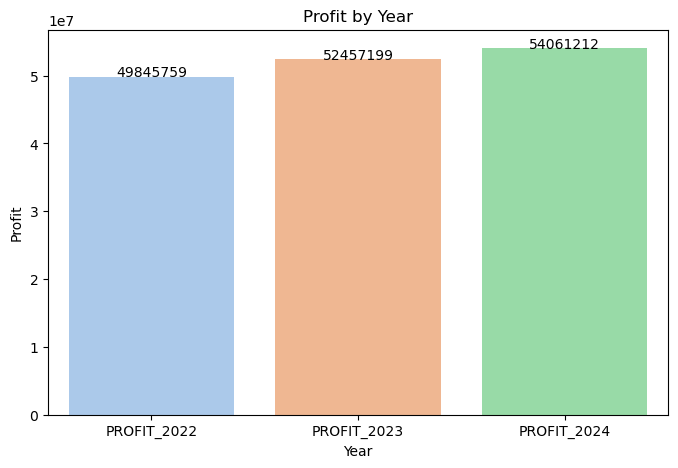

In [39]:
df_long = df.melt(var_name='Year', value_name='Profit')

plt.figure(figsize=(8,5))
sns.barplot(x='Year', y='Profit', data=df_long, palette='pastel')
plt.title("Profit by Year")
plt.xlabel("Year")
plt.ylabel("Profit")

for i, v in enumerate(df_long['Profit']):
    plt.text(i, v + 1000, f"{v:.0f}", ha='center')

plt.show()

Profit growth has been driven by cost reductions rather than revenue expansion, with declining fuel prices serving as the primary contributor. Given that shipment demand remains stable and non-seasonal, margin improvement is best achieved through operational efficiency initiatives. Investing in fuel-efficient and electric vehicles could help control fuel costs and reduce long-term profitability risk.